<a href="https://colab.research.google.com/github/jinayou/abmcore/blob/main/Version_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2023.12.16

- Trading preference formula: Dirichlet
- Spreading preference:
    - Successful traders spread their trading strategies
    - Choose unique strategies from winning strategies (remove those already chosen)
    - When num of opinion groups increases, chose additional new preferences randomly
- Redistribution:
    - Does NOT redistribute preferences when opinion groups converge
    - Does NOT use determine_distributed_earnings


In [ ]:
pip install mesa

In [ ]:
pip install powerlaw

In [ ]:
import mesa
import math
import random
import numpy as np
import copy

In [ ]:
class TraderAgent(mesa.Agent):

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model) # Pass the parameters to the parent class.
        self.trading_preference = self.dirichlet_trading_preference()
        self.latest_trading_decision = 0
        self.earnings = 0
        self.historical_earnings = [] # program not set up yet

    ## Trading prefrence formulas ##
    def dirichlet_trading_preference(self):
        return np.random.dirichlet(np.ones((3,), dtype=int), size=1)[0].tolist() # Choose 3 random nums that add up to 1

    # Generate trading decisions based on probabilities
    def trade(self):
        decision = random.choices([1, -1, 0], weights=self.trading_preference, k=1)[0]
        #1=buy, -1=sell, 0=hold
        return decision

    def step(self):
        self.latest_trading_decision = self.trade()
        # self.historical_earnings.append(self.find_latest_earnings())

        # print(f"Agent {self.unique_id}'s trading preferences: {self.trading_preference}")
        # print(f"Agent {self.unique_id}'s trading decision: {self.latest_trading_decision}")

In [ ]:
class TradingModel(mesa.Model):

    def __init__(self, N, omega, sensitivity):
        self.num_agents = N
        self.schedule = mesa.time.RandomActivation(self)
        self.data_collector = mesa.datacollection.DataCollector(
            agent_reporters={"Latest Trading Decision": "latest_trading_decision"},
            model_reporters={"Traders' Decisions": "agent_decisions", "Returns": "returns_list"}
        )
        self.returns_list = []
        self.earnings_list = []
        self.latest_return = sum(agent.latest_trading_decision for agent in self.schedule.agents)*sensitivity
        self.current_step=1
        self.previous_num_opinion_groups = N

       # Add the agent to the scheduler
        for i in range(self.num_agents):
            self.schedule.add(TraderAgent(i, self))

    ## Trading prefrence formulas ##
    def dirichlet_trading_preference(self):
        return np.random.dirichlet(np.ones((3,), dtype=int), size=1)[0].tolist() # Choose 3 random nums that add up to 1


    ## EARNINGS ##
    def compile_earnings_list(self): #create a list of latest (non-distributed) earnings for all agents
        temp_list=[]
        for agent in self.schedule.agents:
          agent.earnings = -self.latest_return*agent.latest_trading_decision #choose which (buyer/seller) is the winner
          temp_list.append(agent.earnings)
        self.earnings_list = temp_list

    ## Preferences ##
    def assign_preferences(self, r):

        #Determine number of opinion groups
        if r != 0:
            num_opinion_groups = int((self.num_agents / (abs(r)))**omega)
        else:
            num_opinion_groups = int(self.num_agents)
        print("New number of opinion groups:", num_opinion_groups)

        self.spread_preferences(num_opinion_groups)


    def spread_preferences(self, num_opinion_groups):
    #Spread preferences based on whoever was successful in last iteration. If we run out of successful agents, use dirichlet function.

        self.compile_earnings_list()

        # Find indices of successful agents from last iteration
        success_index = []

        for i in range(len(self.earnings_list)):
          if self.earnings_list[i] > 0:
            success_index.append(i)

        trading_preferences = [] #successful trading preferences

        # if number of opinion groups decreased, choose from winning strategies
        for i in range(min(num_opinion_groups, self.previous_num_opinion_groups)):
            if i < len(success_index):
              # No overlap
              choice = success_index.pop(random.randrange(len(success_index)))
              trading_preferences.append(self.schedule.agents[choice].trading_preference)
            else:
              trading_preferences.append(self.dirichlet_trading_preference())

        # if number of opinion groups increases, append new random preference to make up difference
        for i in range(num_opinion_groups - self.previous_num_opinion_groups):
            trading_preferences.append(self.dirichlet_trading_preference())

        print(trading_preferences)

        self.previous_num_opinion_groups = num_opinion_groups

        num_agents = len(self.schedule.agents)

        # Assign agents evenly to the opinion groups
        for i in range(num_agents):
          self.schedule.agents[i].trading_preference = trading_preferences[i % num_opinion_groups]


    def step(self):

        print("------------------------Beginning of step", self.current_step, "------------------------")
        self.current_step+=1

        # Advance the model by one step
        self.assign_preferences(self.latest_return/sensitivity)
        self.schedule.step()
        self.data_collector.collect(self)

        agent_decisions = [agent.latest_trading_decision for agent in self.schedule.agents]
        # print("Traders' Decisions:", agent_decisions)

        # Calculate and store the cumulative trading decisions from all agents
        self.latest_return = sum(agent.latest_trading_decision for agent in self.schedule.agents)*sensitivity
        print("Return:", self.latest_return)
        self.returns_list.append(self.latest_return)
        # print("Historical Returns:", self.returns_list)

In [ ]:
### RUN MODEL ###

## Parameters

#Sensitivity to price change
sensitivity = 1

#Power of omega term
omega = 1 #Check if omega is incorporated correctly

#Trading velocity
V=1.64
Vf=0.4
Vc=(V - 0.83*Vf)/(1- 0.83)
print(Vc)

#Daily trading probability
p=Vc/(250*2)
q=p
#h=1-p-q

## Run

p_hold=0.4

model = TradingModel(1000, omega, sensitivity) #Number of traders
for i in range(3627): #Number of time steps
    model.step()

print("Returns at Each Step:", model.returns_list)

#Test
# print(model.schedule.agents[1].historical_earnings)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
New number of opinion groups: 2
[[0.6136821711611892, 0.19469210635342568, 0.19162572248538506], [0.6136821711611892, 0.19469210635342568, 0.19162572248538506]]
Return: 401
------------------------Beginning of step 2379 ------------------------
New number of opinion groups: 2
[[0.6136821711611892, 0.19469210635342568, 0.19162572248538506], [0.6136821711611892, 0.19469210635342568, 0.19162572248538506]]
Return: 441
------------------------Beginning of step 2380 ------------------------
New number of opinion groups: 2
[[0.6136821711611892, 0.19469210635342568, 0.19162572248538506], [0.6136821711611892, 0.19469210635342568, 0.19162572248538506]]
Return: 471
------------------------Beginning of step 2381 ------------------------
New number of opinion groups: 2
[[0.6136821711611892, 0.19469210635342568, 0.19162572248538506], [0.6136821711611892, 0.19469210635342568, 0.19162572248538506]]
Return: 435
--------------

In [ ]:
output_returns = model.returns_list

In [ ]:
### SAVE THE RESULT IN CSV ###

# This is causing error

'''from google.colab import drive
import csv

# Mount Google Drive
drive.mount('/content/drive')

# Define the file path
file_path = "/content/drive/MyDrive/ABMcore/Output/Output_returns.csv"

# Writing to CSV file
with open(file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(output_returns)'''

'from google.colab import drive\nimport csv\n\n# Mount Google Drive\ndrive.mount(\'/content/drive\')\n\n# Define the file path\nfile_path = "/content/drive/MyDrive/ABMcore/Output/Output_returns.csv"\n\n# Writing to CSV file\nwith open(file_path, \'w\', newline=\'\') as csvfile:\n    csv_writer = csv.writer(csvfile)\n    csv_writer.writerow(output_returns)'



ANALYSIS

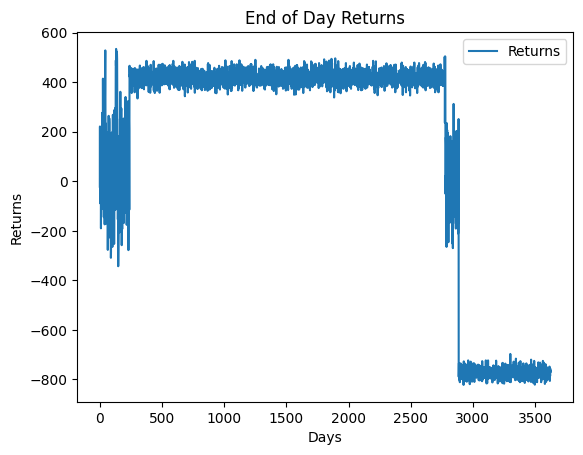

<ipython-input-11-21cbfee64406>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(output_returns, hist=True, kde=False,


[22, 221, 89, 205, 123, 175, 59, 74, 69, 190, 68, 107, 83, 80, 93, 67, 2, 50, 276, 110, 22, 19, 69, 29, 71, 414, 169, 116, 110, 344, 14, 11, 145, 171, 27, 28, 86, 22, 31, 174, 325, 315, 434, 478, 528, 389, 67, 193, 233, 108, 171, 54, 59, 57, 34, 32, 162, 142, 140, 143, 99, 17, 11, 127, 277, 134, 198, 132, 44, 22, 66, 264, 228, 21, 2, 20, 254, 238, 127, 59, 68, 97, 106, 164, 99, 92, 79, 186, 233, 309, 283, 124, 251, 156, 47, 26, 21, 197, 233, 65, 144, 265, 192, 72, 56, 268, 87, 34, 4, 23, 213, 130, 105, 4, 35, 253, 93, 97, 288, 98, 2, 18, 273, 106, 77, 296, 115, 283, 457, 488, 466, 534, 514, 525, 524, 507, 513, 503, 513, 493, 333, 186, 141, 15, 64, 154, 98, 182, 343, 263, 225, 144, 69, 16, 30, 163, 24, 2, 29, 206, 13, 79, 252, 59, 55, 361, 70, 81, 112, 72, 43, 117, 281, 294, 83, 174, 258, 159, 70, 152, 193, 34, 76, 55, 49, 59, 92, 96, 150, 18, 25, 253, 74, 76, 168, 84, 137, 110, 163, 109, 77, 68, 98, 103, 116, 222, 276, 340, 183, 17, 6, 128, 197, 74, 21, 21, 176, 117, 96, 137, 2, 28, 15

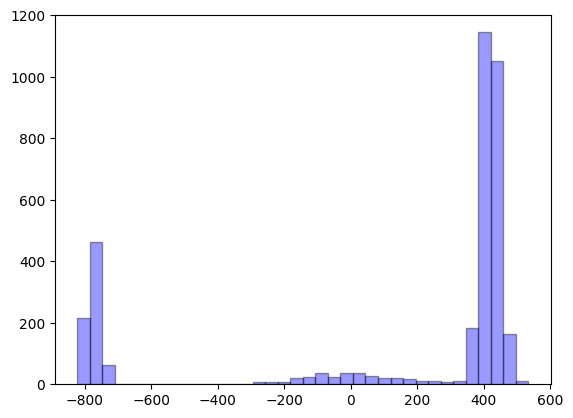

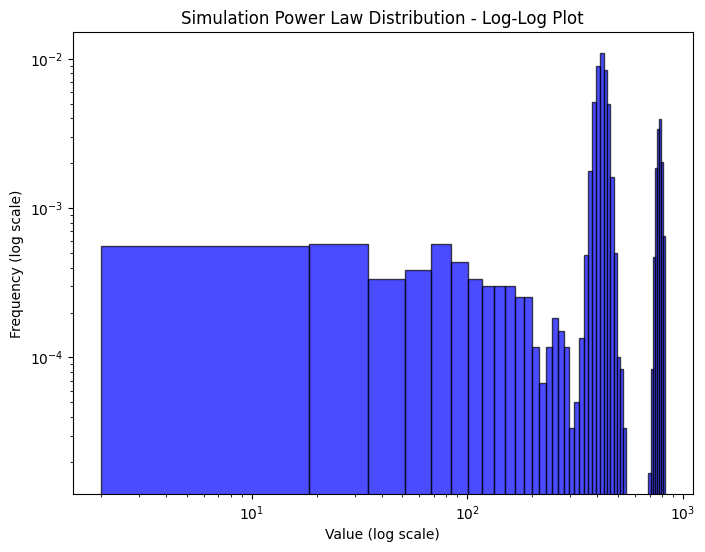

[INFO] computing Hill Estimators...
2

Sample size n: 3627
Total number of exceeded k: 3626


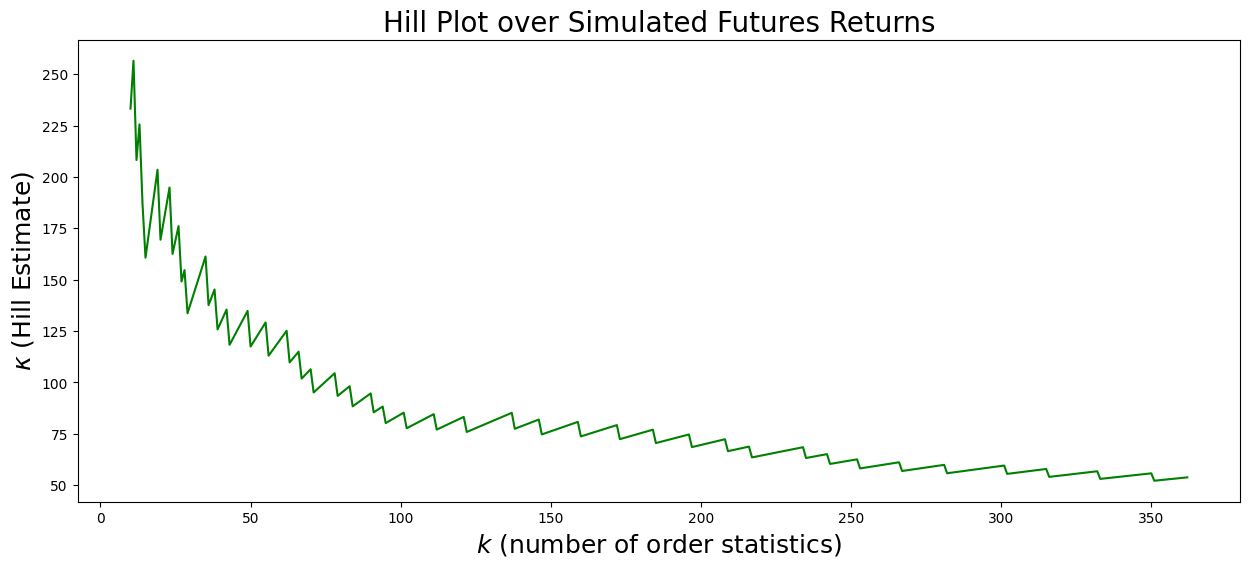

In [ ]:
import matplotlib.pyplot as plt
import powerlaw
import pandas as pd
import seaborn as sns

## PLOT SIMULATION ##

# Plot returns
plt.plot(output_returns, label='Returns')
plt.xlabel('Days')
plt.ylabel('Returns')
plt.title('End of Day Returns')
plt.legend()
plt.show()

# Histogram
sns.distplot(output_returns, hist=True, kde=False,
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

#Option 1
'''data=[]
for i in output_returns:
  data.append(abs(i))
print(data)'''

#Option 2
data=[]
for i in output_returns:
  if abs(i)<2:
    data.append(2)
  else:
    data.append(abs(i))
print(data)

#Option 3
'''data=[]
for i in output_returns:
  if i== 0:
    data.append(0.1)
  else:
    data.append(abs(i))
print(data)'''


# Plot returns on a log-log scale
plt.figure(figsize=(8, 6))
plt.hist(data, bins=50, density=True, alpha=0.7, color='blue', edgecolor = 'black')
plt.xscale('log')
plt.yscale('log')
plt.title('Simulation Power Law Distribution - Log-Log Plot')
plt.xlabel('Value (log scale)')
plt.ylabel('Frequency (log scale)')
plt.show()



### Hill Estimator FOR SIMULATION

# code found on GitHub under the profile AlinaSode

def Hill_estimator(data):
    """
    Returns the Hill Estimators for some 1D data set.
    """
    # sort data in such way that the smallest value is first and the largest value comes last:
    Y = np.sort(data)
    n = len(Y)

    Hill_est = np.zeros(n-1)

    for k in range(0, n-1):    # k = 0,...,n-2
        summ = 0

        for i in range(0,k+1):   # i = 0, ..., k
            summ += np.log(Y[n-1-i]) - np.log(Y[n-2-k])

        Hill_est[k] = (1 / (k+1)) * summ      # add 1 to k because of Python syntax

    kappa = 1. / Hill_est
    return kappa


n_obs = len(data)
k_max = int(round(0.1*n_obs))
k_min = 10

print("[INFO] computing Hill Estimators...")
#t0 = time()
print(min(data))
kap_gains_sim = Hill_estimator(data)

#print ("        done in %0.3f minutes" % ((time() - t0)/60))
print ("")

print ("Sample size n:", n_obs)
print ("Total number of exceeded k:", len(kap_gains_sim))


""" Hill Plot for Gains for k in range (10,...,round(0.1*n_obs)) """

plt.figure(figsize=(15, 6))
plt.plot(np.arange(k_min,k_max), kap_gains_sim[k_min-1:k_max-1], 'green')
plt.xlabel("$k$ (number of order statistics)", fontsize=18)
plt.ylabel("$\kappa$ (Hill Estimate)", fontsize=18)
plt.title("Hill Plot over Simulated Futures Returns", fontsize=20)
plt.show()

            Date  Price   Open   High    Low     Vol. Change % Return
0     12/05/2023  2.748  2.702  2.785  2.678             2.00%   0.02
1     12/04/2023  2.694  2.728  2.752  2.649  161.79K   -4.26%  -0.04
2     12/01/2023  2.814  2.809  2.844  2.754  133.19K    0.43%   0.00
3     11/30/2023  2.802  2.799  2.855  2.761  147.75K   -0.07%   0.00
4     11/29/2023  2.804  2.792   2.87   2.76  141.59K    3.62%   0.04
...          ...    ...    ...    ...    ...      ...      ...    ...
3623  01/08/2010  5.749  5.827  5.853  5.621  101.15K   -0.98%  -0.01
3624  01/07/2010  5.806  6.033  6.108  5.763  135.11K   -3.38%  -0.03
3625  01/06/2010  6.009   5.69  6.075   5.65  140.61K    6.60%   0.07
3626  01/05/2010  5.637  5.837  5.858  5.615   99.49K   -4.20%  -0.04
3627  01/04/2010  5.884  5.705  5.894  5.705   78.86K    5.60%   0.06

[3628 rows x 8 columns]
0       0.0200
1       0.0426
2       0.0043
3       0.0007
4       0.0362
         ...  
3623    0.0098
3624    0.0338
3625    0.0660


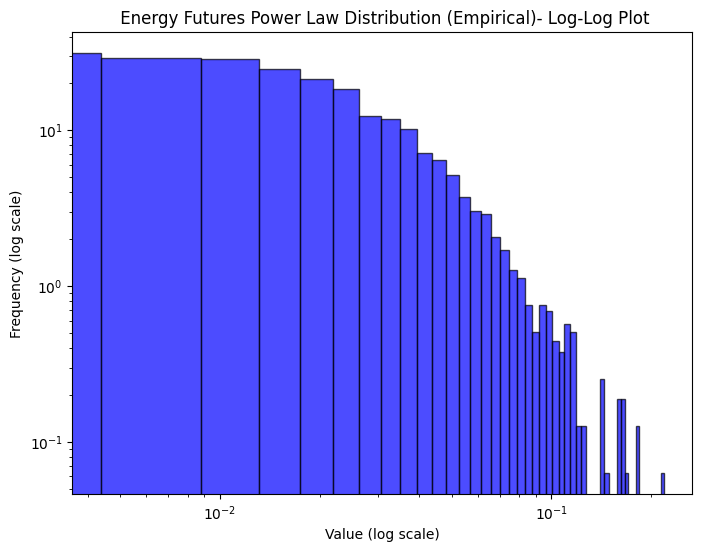

In [ ]:
## READ IN NATURAL GAS FUTURES DATA

## Load data from the drive

from google.colab import auth
auth.authenticate_user()

import gspread

# method 1
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

gsheets = gc.open_by_url('https://docs.google.com/spreadsheets/d/1VMZvoSCBruftaPjW7XwjlsjZBfLdOQ3BKNY2WiC46eE/edit?usp=drive_link')
sheets = gsheets.worksheet('Natural Gas Futures Historical Data').get_all_values()
futures_data = pd.DataFrame(sheets[1:], columns=sheets[0])

# method 2
'''
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

#Path to the data will likely change for you
path = "/content/drive/MyDrive/ABMcore/Data/Gas_futures_data.gsheet"

futures_data=pd.read_csv(path)
'''

print(futures_data)

futures_data["Change"] = futures_data['Change %'].str.rstrip('%').astype('float') / 100.0
fdata = futures_data["Change"].abs()

print(fdata)

## PLOT NATURAL GAS FUTURES DATA
# Plot the data on a log-log scale
plt.figure(figsize=(8, 6))
plt.hist(fdata, bins=50, density=True, alpha=0.7, color='blue', edgecolor = 'black')
plt.xscale('log')
plt.yscale('log')
plt.title(' Energy Futures Power Law Distribution (Empirical)- Log-Log Plot')
plt.xlabel('Value (log scale)')
plt.ylabel('Frequency (log scale)')
plt.show()


[INFO] computing Hill Estimators...


<ipython-input-11-21cbfee64406>:76: RuntimeWarning: divide by zero encountered in log
  summ += np.log(Y[n-1-i]) - np.log(Y[n-2-k])
<ipython-input-11-21cbfee64406>:76: RuntimeWarning: invalid value encountered in double_scalars
  summ += np.log(Y[n-1-i]) - np.log(Y[n-2-k])



Sample size n: 3628
Total number of exceeded k: 3627


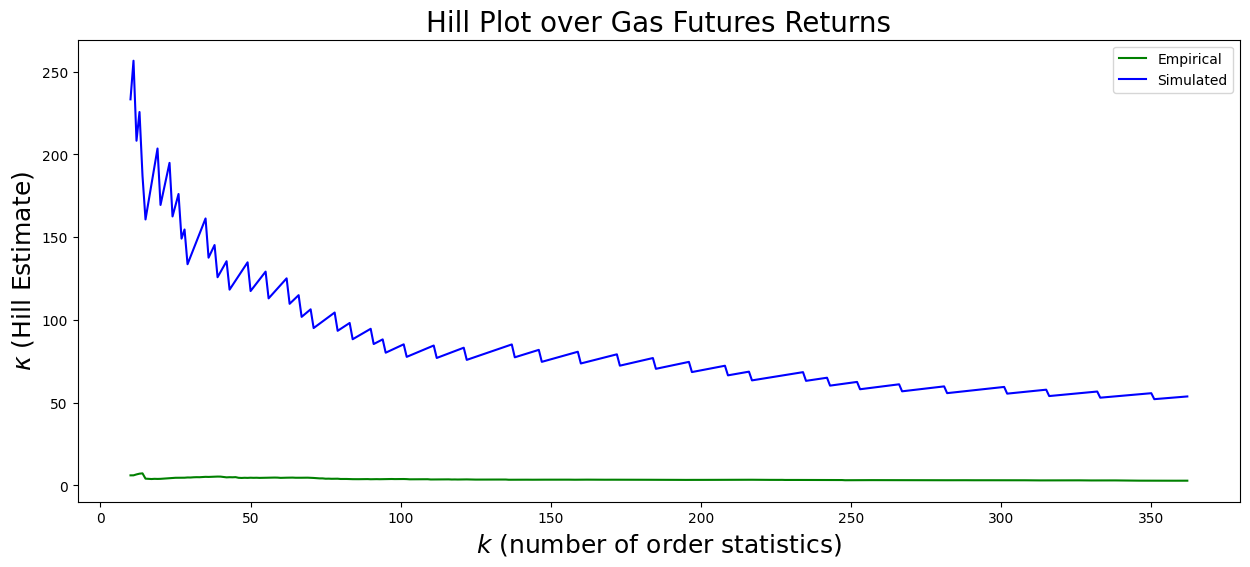

[821.49989856 328.11968638 307.35882956 272.97147938 240.64788181
 288.77745817 336.90703453 261.54749527 294.24093218 233.29246188
 256.62170807 208.27646001 225.63283168 187.04949454 160.71866404
 171.43324164 182.14781925 192.86239685 203.57697445 169.48158675
 177.95566609 186.42974543 194.90382477 162.54121894 169.31376973
 176.08632052 149.13004589 154.65338093 133.66312661 138.27219994
 142.88127327 147.4903466  152.09941993 156.70849326 161.3175666
 137.61432141 141.43694145 145.25956149 125.799221   129.02484205
 132.2504631  135.47608415 118.30504452 121.05632462 123.80760473
 126.55888483 129.31016494 132.06144504 134.81272515 117.45500361
 119.80410368 122.15320375 124.50230383 126.8514039  129.20050397
 113.02242928 115.04068695 117.05894461 119.07720228 121.09545995
 123.11371761 125.13197528 109.74089736 111.48281636 113.22473537
 114.96665437 101.85819688 103.37846847 104.89874007 106.41901166
  95.09997773  96.43941403  97.77885034  99.11828665 100.45772295
 101.797159

In [ ]:
## HILL ESTMATOR FOR GAS FUTURES ##

n_obs = len(fdata)
k_max = int(round(0.1*n_obs))
k_min = 10

print("[INFO] computing Hill Estimators...")
#t0 = time()

kap_gains = Hill_estimator(fdata)


print ("")

print ("Sample size n:", n_obs)
print ("Total number of exceeded k:", len(kap_gains))


""" Hill Plot for Gains for k in range (10,...,round(0.1*n_obs)) """

plt.figure(figsize=(15, 6))
plt.plot(np.arange(k_min,k_max), kap_gains[k_min-1:k_max-1], 'green', label = 'Empirical')
plt.plot(np.arange(k_min,k_max), kap_gains_sim[k_min-1:k_max-1], 'blue', label = 'Simulated')
plt.legend()
plt.xlabel("$k$ (number of order statistics)", fontsize=18)
plt.ylabel("$\kappa$ (Hill Estimate)", fontsize=18)
plt.title("Hill Plot over Gas Futures Returns", fontsize=20)
plt.show()
print(kap_gains_sim[0:100])
print(kap_gains[0:100])
print('kap_gains_sim', kap_gains_sim[72])
ratio = []
for i in range(100):
  ratio.append(kap_gains_sim[i]/kap_gains[i])
print(ratio)